## Mixed layer tracer structure

In this notebook we explore the structure of the mixed layer. The properties we look at are: 
- Homogeneity of the mixed layer as a function of time/space. 
- Are density gradients in the ML constructed by T or S, or both? 


In [90]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [91]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [92]:
import hvplot.xarray
import panel as pn
pn.extension()

In [4]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_binned_29_june_2021.nc')

In [5]:
# drop profiles where we don't have data near the surface.
ds_660_grid = ds_660_grid.where(~np.isnan(ds_660_grid.sigma0.sel(ctd_pressure=15, method='nearest')), drop=True)

In [6]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1003)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 27.03 27.02 27.02 ... nan nan
    SA            (ctd_pressure, dives) float64 34.15 34.15 34.15 ... nan nan
    CT            (ctd_pressure, dives) float64 3.59 3.618 3.617 ... nan nan nan
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 -51.5 -51.49 -51.48 ... nan nan
    longitude     (ctd_pressure, dives) float64 30.03 30.03 30.05 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

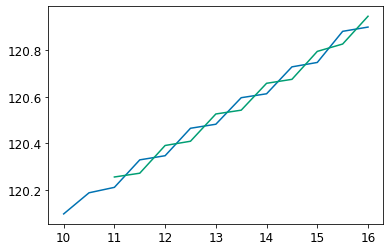

In [7]:
days = ds_660_grid.time - np.datetime64('2019-01-01')
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

temp_var = ds_660_grid['days'].sel(dives=slice(10,16))
plt.plot(temp_var.dives, temp_var.sel(ctd_pressure=30, method='nearest'))
plt.plot(temp_var.dives, temp_var.sel(ctd_pressure=800, method='nearest'))

In [8]:
ds_660_grid.load()

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1003)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 27.03 27.02 27.02 ... nan nan
    SA            (ctd_pressure, dives) float64 34.15 34.15 34.15 ... nan nan
    CT            (ctd_pressure, dives) float64 3.59 3.618 3.617 ... nan nan nan
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 -51.5 -51.49 -51.48 ... nan nan
    longitude     (ctd_pressure, dives) float64 30.03 30.03 30.05 ... nan nan
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

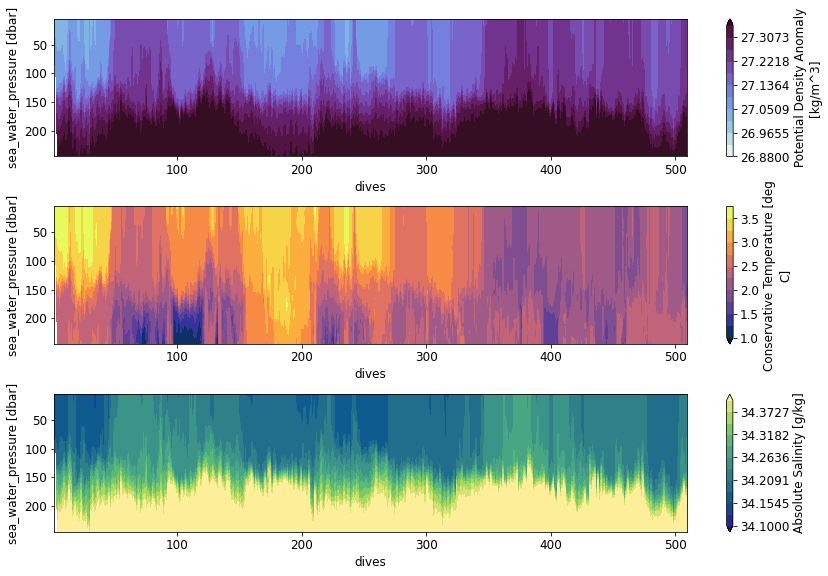

In [9]:
plt.figure(figsize=(12,8))

plt.subplot(311)
ds_660_grid.sigma0.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(26.88, 27.35,12), 
                                                                                   cmap=cmo.dense)
plt.gca().invert_yaxis()

plt.subplot(312)
ds_660_grid.CT.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(1, 3.75,12),
                                                                     cmap=cmo.thermal)
plt.gca().invert_yaxis()

plt.subplot(313)
ds_660_grid.SA.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(34.1, 34.4,12),
                                                                  cmap=cmo.haline)
plt.gca().invert_yaxis()

plt.tight_layout()

### Near surface layer properties

In [10]:
SA_lin = np.linspace(34.0, 34.3, 51)
CT_lin = np.linspace(1.5, 4, 51)

[SA_grid, CT_grid] = np.meshgrid(SA_lin, CT_lin)

rho_grid = gsw.sigma0(SA_grid, CT_grid)

Text(0, 0.5, 'CT')

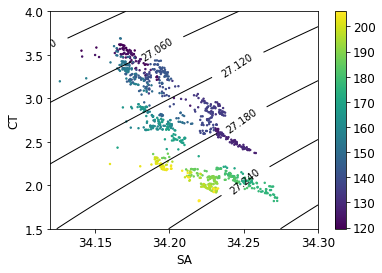

In [11]:

CS = plt.contour(SA_lin, CT_lin, rho_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            s=2.,
            c=ds_660_grid.days.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'))
plt.colorbar()

plt.xlim([34.12, 34.3])
plt.xlabel('SA')
plt.ylabel('CT')

Text(0, 0.5, 'CT')

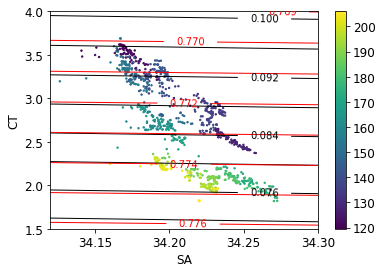

In [12]:
rho0=1000
alpha_grid = gsw.alpha(SA_grid, CT_grid,50)*rho0
beta_grid = gsw.beta(SA_grid, CT_grid,50)*rho0

CS = plt.contour(SA_lin, CT_lin, alpha_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)

CS = plt.contour(SA_lin, CT_lin, beta_grid, linewidths=1, colors='r')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            s=2.,
            c=ds_660_grid.days.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'))
plt.colorbar()


plt.xlim([34.12, 34.3])
plt.xlabel('SA')
plt.ylabel('CT')

In [13]:
# Estimate the alpha and beta 

alpha = (gsw.alpha(34.20, 2.75, 0))
beta = (gsw.beta(34.20, 2.75, 0))

drho = .3
dt = drho/alpha/1000
ds = drho/beta/1000

display(alpha)
display(beta)

8.468229088219696e-05

0.0007731467820367002

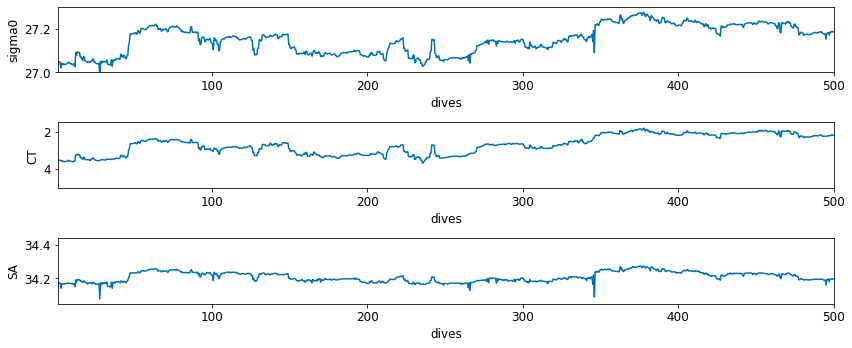

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(311)
ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,500])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,500])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,500])

plt.tight_layout()


### Mixed layer 

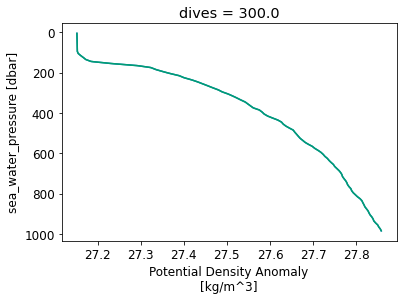

In [15]:
ds_660_grid.sigma0.sel(dives=300).plot(y='ctd_pressure')
ds_660_grid.sigma0.sel(dives=300).interp(ctd_pressure=np.linspace(0,1000,501)).plot(y='ctd_pressure')
plt.gca().invert_yaxis()

In [16]:
def find_mld(ds, thresh=0.03):
    
    dens= ds.sigma0.interp(ctd_pressure=np.linspace(0,1000,501))
    temp = ds.CT.interp(ctd_pressure=np.linspace(0,1000,501))
    salt = ds.SA.interp(ctd_pressure=np.linspace(0,1000,501))
    
    time = ds.days.interp(ctd_pressure=np.linspace(0,1000,501))    
    lat = ds.latitude.interp(ctd_pressure=np.linspace(0,1000,501))    
    lon = ds.longitude.interp(ctd_pressure=np.linspace(0,1000,501))    
    
    
    #dens = dens.interp(ctd_pressure=np.linspace(0,1000,501))
    
    dens15 = dens.sel(ctd_pressure = 15., method='nearest')
    
    delta_dens = dens - dens15
    delta_dens_crit = delta_dens.where(delta_dens>=thresh)
    
    MLD = delta_dens.ctd_pressure.where(delta_dens==
                                    delta_dens_crit.min(['ctd_pressure'])
                                       ).max(['ctd_pressure']).rename('mld')
    
    MLD_temp = temp.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_salt = salt.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_dens = dens.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    
    MLD_time = time.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_lat = lat.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_lon = lon.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    
    
    mld_properties = xr.merge([MLD,
                               MLD_temp, MLD_salt, MLD_dens, 
                               MLD_time, MLD_lat, MLD_lon])
    
    return mld_properties

In [17]:
MLD = find_mld(ds_660_grid, thresh=0.03)


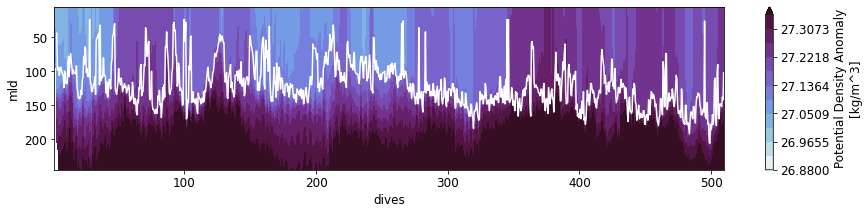

In [18]:
plt.figure(figsize=(15,3))
ds_660_grid.sigma0.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(26.88, 27.35,12), 
                                                                                   cmap=cmo.dense)
MLD.mld.plot(color='w')
plt.gca().invert_yaxis()

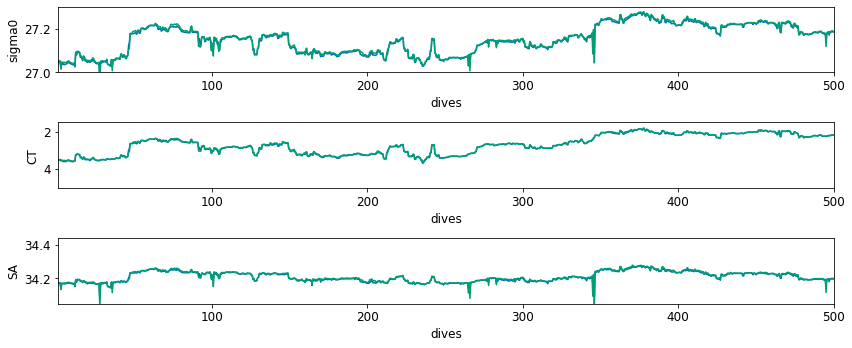

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(311)
ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.sigma0.plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,500])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.CT.plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,500])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.SA.plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,500])

plt.tight_layout()
# looks the same whether using 10-50m or full ML 

In [20]:
MLD.mld.hvplot(flip_yaxis=True)

:Curve   [dives]   (mld)

#### Check out what is going on with really shallow MLDs

This set looks like it is from the south, as indicated by deep cold anomaly. 

In [93]:
n=0
for i in [125, 126, 127,128, 129, 130]:
    if n==0:
        plot = ds_660_grid.sigma0.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.sigma0.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I   :Curve   [ctd_pressure]   (sigma0)
   .Curve.II  :Curve   [ctd_pressure]   (sigma0)
   .Curve.III :Curve   [ctd_pressure]   (sigma0)
   .Curve.IV  :Curve   [ctd_pressure]   (sigma0)
   .Curve.V   :Curve   [ctd_pressure]   (sigma0)
   .Curve.VI  :Curve   [ctd_pressure]   (sigma0)

In [94]:
n=0
for i in [125, 126, 127,128, 129, 130]:
    if n==0:
        plot = ds_660_grid.CT.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.CT.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I   :Curve   [ctd_pressure]   (CT)
   .Curve.II  :Curve   [ctd_pressure]   (CT)
   .Curve.III :Curve   [ctd_pressure]   (CT)
   .Curve.IV  :Curve   [ctd_pressure]   (CT)
   .Curve.V   :Curve   [ctd_pressure]   (CT)
   .Curve.VI  :Curve   [ctd_pressure]   (CT)

In [95]:
n=0
for i in [125, 126, 127,128, 129, 130]:
    if n==0:
        plot = ds_660_grid.SA.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.SA.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I   :Curve   [ctd_pressure]   (SA)
   .Curve.II  :Curve   [ctd_pressure]   (SA)
   .Curve.III :Curve   [ctd_pressure]   (SA)
   .Curve.IV  :Curve   [ctd_pressure]   (SA)
   .Curve.V   :Curve   [ctd_pressure]   (SA)
   .Curve.VI  :Curve   [ctd_pressure]   (SA)

There are also some really fresh lenses sitting at the surface. 

In [96]:
shallow_mlds = MLD.mld.where(MLD.mld<40, drop=True)
shallow_mlds

<xarray.DataArray 'mld' (dives: 18)>
array([24., 32., 36., 30., 36., 32., 28., 24., 24., 28., 34., 32., 30.,
       26., 36., 24., 24., 26.])
Coordinates:
  * dives    (dives) float64 28.0 36.0 46.5 47.0 ... 278.0 345.0 346.0 495.0

In [97]:
n=0
for i in shallow_mlds.dives:
    if n==0:
        plot = ds_660_grid.sigma0.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.sigma0.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I     :Curve   [ctd_pressure]   (sigma0)
   .Curve.II    :Curve   [ctd_pressure]   (sigma0)
   .Curve.III   :Curve   [ctd_pressure]   (sigma0)
   .Curve.IV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.V     :Curve   [ctd_pressure]   (sigma0)
   .Curve.VI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.VII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.VIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.IX    :Curve   [ctd_pressure]   (sigma0)
   .Curve.X     :Curve   [ctd_pressure]   (sigma0)
   .Curve.XI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIV   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVI   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVIII :Curve   [ctd_pressure]   (sigma0)

In [98]:
n=0
for i in shallow_mlds.dives:
    if n==0:
        plot = (ds_660_grid.sigma0 - ds_660_grid.sigma0.sel(ctd_pressure=0, method='nearest')).sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*(ds_660_grid.sigma0 - ds_660_grid.sigma0.sel(ctd_pressure=0, method='nearest')).sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I     :Curve   [ctd_pressure]   (sigma0)
   .Curve.II    :Curve   [ctd_pressure]   (sigma0)
   .Curve.III   :Curve   [ctd_pressure]   (sigma0)
   .Curve.IV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.V     :Curve   [ctd_pressure]   (sigma0)
   .Curve.VI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.VII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.VIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.IX    :Curve   [ctd_pressure]   (sigma0)
   .Curve.X     :Curve   [ctd_pressure]   (sigma0)
   .Curve.XI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIV   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVI   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVIII :Curve   [ctd_pressure]   (sigma0)

### Start considering distances. 

First consider a couple of options for distances. 

In [27]:
MLD

<xarray.Dataset>
Dimensions:    (dives: 1003)
Coordinates:
  * dives      (dives) float64 1.0 1.5 2.0 2.5 3.0 ... 508.0 508.5 509.0 509.5
Data variables:
    mld        (dives) float64 nan nan nan nan 44.0 ... 152.0 138.0 142.0 102.0
    CT         (dives) float64 3.543 3.535 3.501 3.493 ... 1.812 1.818 1.793
    SA         (dives) float64 34.18 34.17 34.17 34.17 ... 34.22 34.22 34.23
    sigma0     (dives) float64 27.05 27.05 27.05 27.05 ... 27.24 27.24 27.24
    days       (dives) float64 119.5 119.5 119.5 119.6 ... 205.8 205.8 206.0
    latitude   (dives) float64 -51.49 -51.49 -51.48 ... -51.54 -51.53 -51.52
    longitude  (dives) float64 30.03 30.03 30.05 30.05 ... 38.98 38.99 39.03

In [28]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [29]:
# convert to distance coordinate

# set coordinates at 30E lon and -54S
ref_x = 29.9,
ref_y = -54
deg2m = 111139.

def lonlat2xy(ds, ref_x, reg_y):
    deg2m = 111139.
    
    X = great_circle_distance(ds.longitude, ds.latitude, 
                              ref_x, ds.latitude)*deg2m
    Y = great_circle_distance(ds.longitude, ds.latitude, 
                              ds.longitude, ref_y)*deg2m

    return X.rename('X'), Y.rename('Y')


In [30]:
MLD['X'], MLD['Y'] = lonlat2xy(xr.merge([MLD.longitude, MLD.latitude]), ref_x, ref_y)

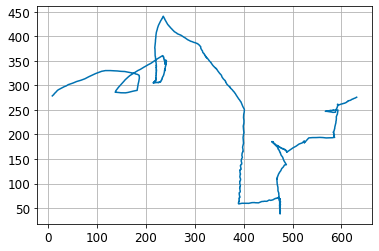

In [31]:
plt.plot(MLD.X/1e3, MLD.Y/1e3)
plt.grid()

In [32]:
# Estimate along track distance
dist = gt.utils.distance(MLD.longitude, MLD.latitude)

MLD['distance'] = xr.DataArray(np.cumsum(dist), 
                               dims= ['dives'])

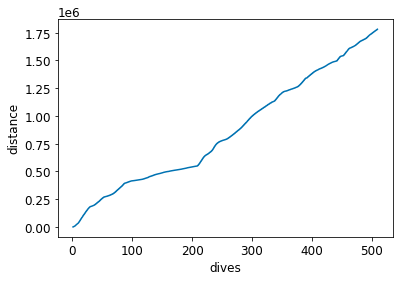

In [33]:
MLD['distance'].plot()

### Density Ratios and Turner Angles

The density ratio is defined as 
\begin{equation}
R = \frac{\alpha dT}{\beta dS}.
\end{equation}
R = 1 when T and S gradients compensate (no corresponding gradient in density), and can take values between $- \infty$ and $\infty$.

Corresponding Turner angle can be defined, which reduces to a finite range
\begin{equation}
Tu = \tan^{-1}(R)
\end{equation}

- R = 1, Tu=45, Compensation
- R = 0, Tu=0, Salinity dominated
- R = -1, Tu=-45, Alignment


In [34]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time_no_pres(ds, var): 
    time_grid = np.arange(120, 205, 1/24)

   
    #for i in range(len(ds.ctd_pressure)):
    #    ds_temp =ds.isel(ctd_pressure=i)
    #    f = interpolate.interp1d(ds_temp.days, ds_temp[var])
    f = interpolate.interp1d(ds.days, ds[var])
    var_int = f(time_grid)
        
    da_var_int = xr.DataArray(var_int,
                                   dims=["days"],
                                   coords={"days": time_grid}
                                   ).rename(var)
        
#    if i==0:
#         da_var_int = da_var_int_temp
#    else:
#        da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [35]:
MLD_time = xr.merge([interp_time_no_pres(MLD,'sigma0'),
                        interp_time_no_pres(MLD,'CT'),
                        interp_time_no_pres(MLD,'SA')])

In [36]:
MLD_time

<xarray.Dataset>
Dimensions:  (days: 2040)
Coordinates:
  * days     (days) float64 120.0 120.0 120.1 120.1 ... 204.8 204.9 204.9 205.0
Data variables:
    sigma0   (days) float64 27.05 27.05 27.04 27.04 ... 27.21 27.21 27.21 27.22
    CT       (days) float64 3.539 3.566 3.575 3.585 ... 2.1 2.106 2.088 2.058
    SA       (days) float64 34.18 34.17 34.17 34.17 ... 34.22 34.22 34.22 34.22

Text(0, 0.5, 'CT')

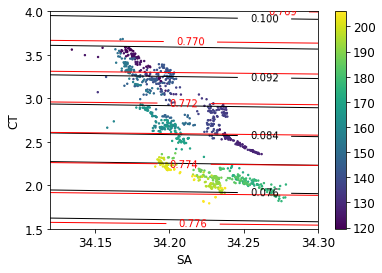

In [37]:

rho0=1000
alpha_grid = gsw.alpha(SA_grid, CT_grid,50)*rho0
beta_grid = gsw.beta(SA_grid, CT_grid,50)*rho0

CS = plt.contour(SA_lin, CT_lin, alpha_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)

CS = plt.contour(SA_lin, CT_lin, beta_grid, linewidths=1, colors='r')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(MLD.SA, 
            MLD.CT, 
            s=2.,
            c=MLD.days)
plt.colorbar()


plt.xlim([34.12, 34.3])
plt.xlabel('SA')
plt.ylabel('CT')

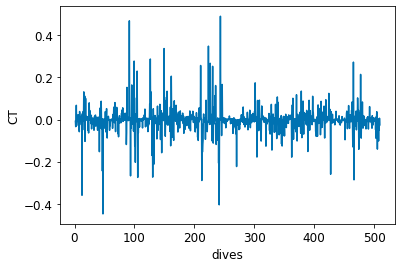

In [38]:
MLD.CT.diff('dives').plot()

In [39]:
#ds_660_time.CT.diff('days').sel(ctd_pressure=depth, method='nearest').plot()

NameError: name 'ds_660_time' is not defined

In [40]:
alphadT = alpha* MLD.CT.diff('dives') *rho0
betadS = beta* MLD.SA.diff('dives')*rho0
R_dives = alphadT/betadS


alphadT = alpha* MLD_time.CT.diff('days') *rho0
betadS = beta* MLD_time.SA.diff('days')*rho0
R_time = alphadT/betadS

#alphadT = alpha*ds_660_time.CT.sel(ctd_pressure=depth, method='nearest').diff('days')*rho0
#betadS = beta*ds_660_time.SA.sel(ctd_pressure=depth, method='nearest').diff('days')*rho0

R = alphadT/betadS

In [41]:
Tu_dives = np.arctan(R_dives)
Tu_time = np.arctan(R_time)
Tu = np.arctan(R)

Text(0, 0.5, '$\\beta$ dS')

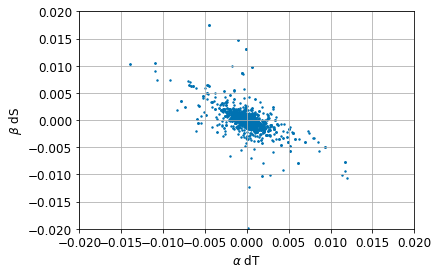

In [42]:
plt.scatter(alphadT, betadS, s=2.)
lims = [-0.02, 0.02]
plt.xlim(lims)
plt.ylim(lims)

plt.grid()

plt.xlabel(r'$\alpha$ dT')
plt.ylabel(r'$\beta$ dS')

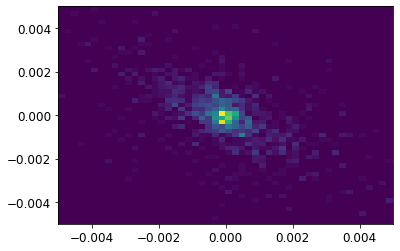

In [43]:
plt.hist2d(alphadT, betadS, bins=np.linspace(-0.005,0.005, 51));

Text(0.5, 0, 'R')

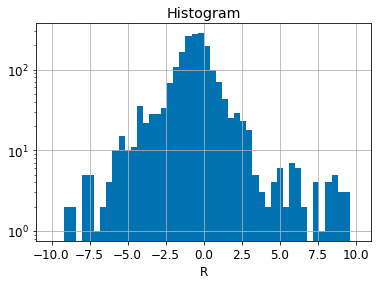

In [44]:
R.plot.hist(bins=np.linspace(-10,10,51));
plt.yscale('log')
plt.grid()
plt.xlabel('R')

Text(0.5, 0, 'Tu')

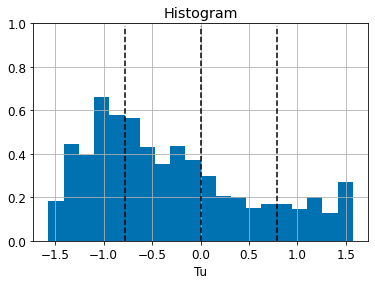

In [45]:
Tu.plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,21), density=True);
#Tu.sel(dives=slice(0,250)).plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,21), density=True, alpha=0.6);
#Tu.sel(dives=slice(250,600)).plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,21), density=True, alpha=0.6);
#plt.yscale('log')
plt.vlines([-np.pi/4 , 0 , np.pi/4], 0, 0.99, colors='k', linestyle='--')
plt.grid()
plt.ylim([0, 1])
plt.xlabel('Tu')

Text(0.5, 0, 'Tu')

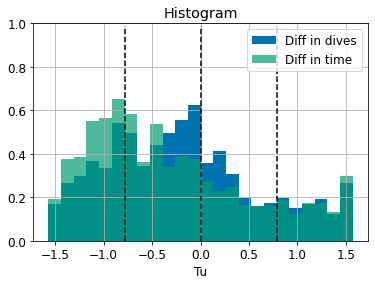

In [47]:
Tu_dives.plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,25), density=True, label='Diff in dives');
Tu_time.plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,25), density=True, alpha=0.7, label='Diff in time');
#plt.yscale('log')
plt.vlines([-np.pi/4 , 0 , np.pi/4], 0, 0.99, colors='k', linestyle='--')
plt.legend()
plt.grid()
plt.ylim([0, 1])
plt.xlabel('Tu')

*Note:* The above result does depend on whether we interpolate in time or not. Interpolating in time results in a peak at Tu=1, while with using dive points a secondary peak at Tu=0 is also present. 

#### Is this a result of close and far dives?

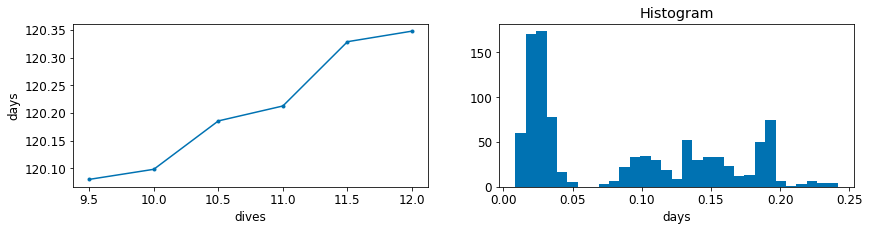

In [48]:
plt.figure(figsize=(14,3))

plt.subplot(121)
MLD.days[14:20].plot(marker='.')

plt.subplot(122)
MLD.days.diff('dives').plot.hist(bins=31);
# we can use the gap in this histogram to look at large and small scales. 

In [49]:
dTime = MLD.days.diff('dives')
dTime

<xarray.DataArray 'days' (dives: 1002)>
array([0.00856336, 0.02514468, 0.0087273 , ..., 0.18656123, 0.03233896,
       0.19654459])
Coordinates:
  * dives    (dives) float64 1.5 2.0 2.5 3.0 3.5 ... 508.0 508.5 509.0 509.5

Text(0, 0.5, 'PDF')

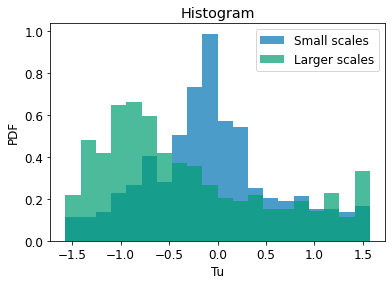

In [50]:
#Tu_dives.plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,25), density=True);
Tu_dives.where(dTime<0.06).plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,21), 
                                     density=True, alpha=0.7, label='Small scales');
Tu_dives.where(dTime>0.06).plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,21), 
                                     density=True, alpha=0.7, label='Larger scales');
plt.legend()
plt.xlabel('Tu')
plt.ylabel('PDF')

The above analysis suggests that in our domain the Tu varies with scale. 
When considering adjacent dives at shorter time (up followed by down), the $Tu\approx 0$ implying that salinity gradients are dominant. 

While at longer time (down followed by up), the $Tu \approx -\pi/4$ implying that salinity and temperature gradients contribute equally to the density gradient. 

This suggests that we might want to look at this in more detail. 

This can be done in a couple of different ways: 
- We can look at the dT and dS as a function of the separations, and then do some binning. 

- Alternatively we can look at the wavelets. Something very similar was done in Ferrari and Rudnick, where they used wavelets. Very similar, as coherence can be imagined as a box-car version of a more sophisticated window used by wavelet (basically they did a fancy coherence calculation). (**The trouble with this approach might be that if we linearly interpolate to a uniform grid, we might artificially downweight the information at smaller scales. **)

### Compensation or Alignment as a function of scale 

#### Visual 

Pro - easy to see  
Con - Only qualitative

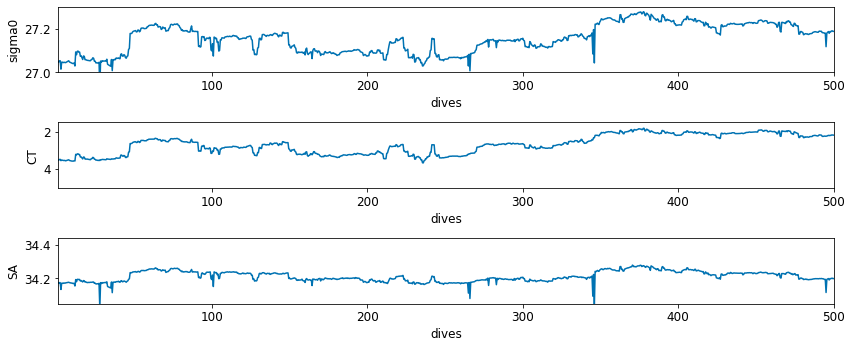

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(311)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.sigma0.plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,500])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
#ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.CT.plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,500])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
#ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.SA.plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,500])

plt.tight_layout()
# looks the same whether using 10-50m or full ML 

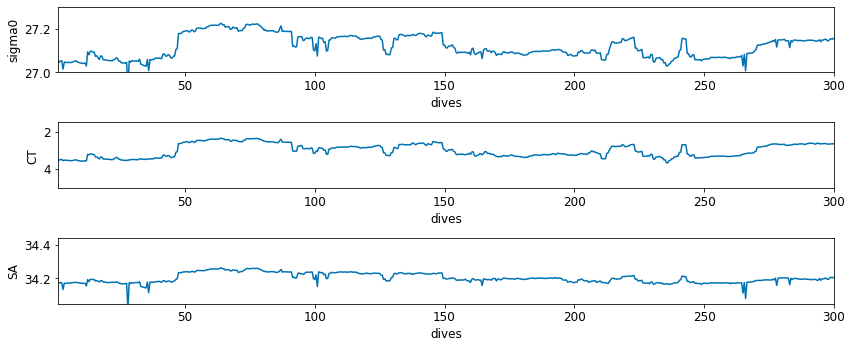

In [52]:
plt.figure(figsize=(12,5))
plt.subplot(311)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.sigma0.plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,300])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
#ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.CT.plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,300])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
#ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.SA.plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,300])

plt.tight_layout()
# looks the same whether using 10-50m or full ML 

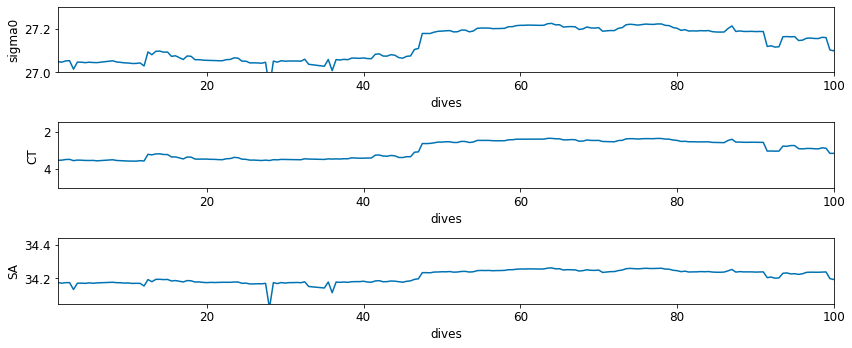

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(311)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.sigma0.plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,100])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
#ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.CT.plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,100])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
#ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.SA.plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,100])

plt.tight_layout()
# looks the same whether using 10-50m or full ML 

Notice that some of the shaper gradients at smaller scales do seem to only show up in salinity and not present in temperature. This is line with the earlier result that the Tu angle is strongly a function of scale. 

#### Coherence

Pro - Quantitative.  
Con - 
- **Only will give information about whether two signals are correlated, and not the degree of correlation. E.g. if y=2x, then coherence/correlation is 1 and we don't get the slope.**
- Requires projecting/interpolating onto a uniform grid (atleast it would be better to).
- We likely can only quantify down to the scales of larger separation (distance between down and up). Valuable information about smaller scales is lost. 
- Since projecting onto time grid makes sense we end up mixing large and small scales depending on glider speeds.


In [54]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(120, 205, 1/24)

   
    for i in range(len(ds.ctd_pressure)):
        ds_temp =ds.isel(ctd_pressure=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var])
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [55]:
ds_660_time = xr.merge([interp_time(ds_660_grid,'sigma0'),
                        interp_time(ds_660_grid,'CT'),
                        interp_time(ds_660_grid,'SA')])

In [56]:
ds_660_time

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, days: 2040)
Coordinates:
  * days          (days) float64 120.0 120.0 120.1 120.1 ... 204.9 204.9 205.0
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
Data variables:
    sigma0        (ctd_pressure, days) float64 27.04 27.04 27.04 ... 27.86 27.86
    CT            (ctd_pressure, days) float64 3.569 3.585 3.608 ... 2.23 2.231
    SA            (ctd_pressure, days) float64 34.17 34.17 34.17 ... 35.05 35.05

In [57]:
# Code based on http://pordlabs.ucsd.edu/sgille/sio221c/lectures/coher.pdf
N = len(ds_660_time.days)
M = int(24*6) # break up into 4 day segments 

segs = int(N/M)

fT = np.complex(1,1)*np.zeros((M, segs))
fS = np.complex(1,1)*np.zeros((M, segs))
depth =50

for n in range( 1, segs+1 ):
    dT = ds_660_time.CT.isel( days= slice((n-1)*M , n*M )).sel(ctd_pressure=depth, method='nearest') * alpha
    dS = ds_660_time.SA.isel( days= slice((n-1)*M , n*M )).sel(ctd_pressure=depth, method='nearest') * beta
    drho = ds_660_time.sigma0.isel( days= slice((n-1)*M , n*M )).sel(ctd_pressure=depth, method='nearest')
    
    dT_prime = dT - dT.mean('days')
    dS_prime = dS - dS.mean('days')
    drho_prime = drho - drho.mean('days')

    fT[:,n-1] = np.fft.fft(dT_prime.values)
    fS[:,n-1] = np.fft.fft(-dS_prime.values)
    
sqrfT = np.mean(np.abs(fT)**2, axis=1) 
sqrfS = np.mean(np.abs(fS)**2, axis=1) 
cofTfS = np.mean(fT*np.conj(fS), axis=1)
C = np.abs(cofTfS)/np.sqrt(sqrfT*sqrfS)
phase = np.arctan2(- np.imag(cofTfS), np.real(cofTfS) )
freq = np.fft.fftfreq(M, d=3600)

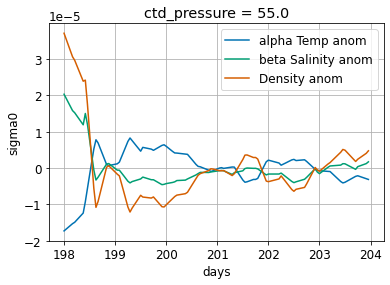

In [58]:
dT_prime.plot(label='alpha Temp anom')
dS_prime.plot(label='beta Salinity anom')
(drho_prime/1e3).plot(label='Density anom')
plt.grid()
plt.legend()

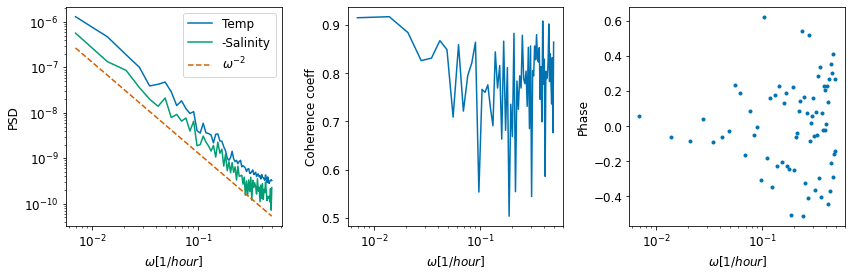

In [59]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.plot(freq[1: int(M/2)]*3600, sqrfT[1: int(M/2)], label='Temp')
plt.plot(freq[1: int(M/2)]*3600, sqrfS[1: int(M/2)], label='-Salinity')
plt.plot(freq[1: int(M/2)]*3600, 1e-18*freq[1: int(M/2)]**-2, linestyle='--', label='$\omega^{-2}$')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$\omega [1/hour]$')
plt.ylabel('PSD')

plt.subplot(132)
plt.plot(freq[1: int(M/2)]*3600, C[1: int(M/2)])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Coherence coeff')
plt.xlabel('$\omega [1/hour]$')

plt.subplot(133)
plt.plot(freq[1: int(M/2)]*3600, phase[1: int(M/2)],'.')
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Phase')
plt.xlabel('$\omega [1/hour]$')

plt.tight_layout()

The above plot shows that the T and S are very well correlated, and have the effect of amplifying their relative effects on density. 

another concern with the above analysis is that we don't have any errorbars. Also it is seen that some of these results (quantitative) are sensitive to the choices.


**Note**: The coherence is computed between alpha dT and -beta dS. 
This is done to keep the phase angle around 0 for anticorrelated signals, otherwise the phase angle can bounce b/w -pi and pi. 

#### Coefficients of Fourier transform

Since the coherence does not tell us about the degree of cancelation (or alignment), we need to look at the coefficients themselves to determine this. 
Ferrari and Rudnick 1999 did this using wavelets. Here we first look at the coefficients of the fourier transforms that we calculated for the coherence. Wavelets are a fancier version of this, which allows for more resolution (here the resolution is controlled by the number of segments). 

One of the problems is that that since there are so few segments it is hard to say anything statistical about whether the compensation/alignment changes with resolution. 

(-0.0003, 0.0003)

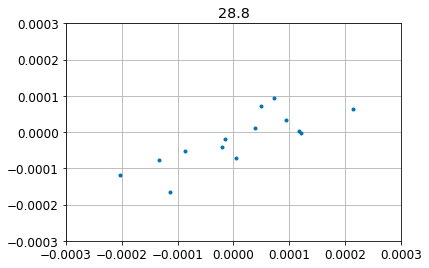

In [60]:
n = 5
plt.plot(fT[n,:], fS[n,:], '.')
plt.grid()
plt.title(1/freq[n]/3600)
plt.xlim([-3e-4, 3e-4])
plt.ylim([-3e-4, 3e-4])

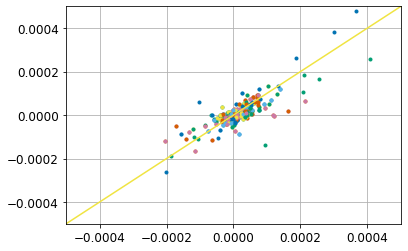

In [61]:
for n in range(1,140, 2):
    plt.plot(np.real(fT[n,:]), np.real(fS[n,:]), '.')
plt.grid()
#plt.title(1/freq[n]/3600)
plt.xlim([-5e-4, 5e-4])
plt.ylim([-5e-4, 5e-4])
x=np.linspace(-1,1)
plt.plot(x,x)

In [62]:
R_fft = np.real(fT)/np.real(-fS)
#plt.hist()
R_fft.shape

(144, 14)

In [63]:
Tu_fft = np.arctan(R_fft)

In [64]:
R_fft.reshape(-1).shape

(2016,)

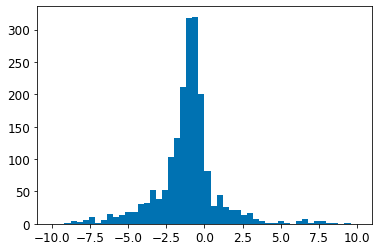

In [65]:
plt.hist( R_fft.reshape(-1), bins=np.linspace(-10, 10, 51));

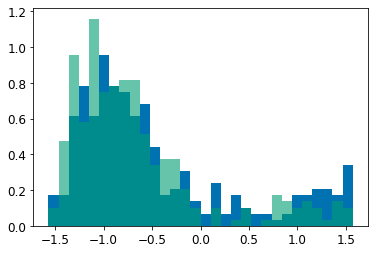

In [66]:
plt.hist( Tu_fft[1:21,:].reshape(-1), bins=np.linspace(-np.pi/2,np.pi/2,31), density=True);
plt.hist( Tu_fft[51:71,:].reshape(-1), bins=np.linspace(-np.pi/2,np.pi/2,31), 
         density=True, alpha=0.6);

Only the larger scale peak is recovered as the the smaller distance data might have been downweighted. 

#### Wavelets

We can try out the above analysis using wavelets to get something that is closer to the Ferrari and Rudnick analysis. 
However, we hesitate to do this for now because of the downweighting problem. 

#### Gradients at different scales

Consider two properties of the gradients:   
a) Scaling of the density gradients with length scales.   
b) Properties of compensation or alignment with length scales.   

In [67]:
#def great_circle_distance(lon1, lat1, lon2, lat2):
def great_circle_distance(X1, X2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    
    # Change form of input to make compliant with pdist
    lon1 = X1[0]
    lat1 = X1[1]
    lon2 = X2[0]
    lat2 = X2[1]
    
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [68]:
from scipy.spatial.distance import pdist

In [69]:
MLD

<xarray.Dataset>
Dimensions:    (dives: 1003)
Coordinates:
  * dives      (dives) float64 1.0 1.5 2.0 2.5 3.0 ... 508.0 508.5 509.0 509.5
Data variables:
    mld        (dives) float64 nan nan nan nan 44.0 ... 152.0 138.0 142.0 102.0
    CT         (dives) float64 3.543 3.535 3.501 3.493 ... 1.812 1.818 1.793
    SA         (dives) float64 34.18 34.17 34.17 34.17 ... 34.22 34.22 34.23
    sigma0     (dives) float64 27.05 27.05 27.05 27.05 ... 27.24 27.24 27.24
    days       (dives) float64 119.5 119.5 119.5 119.6 ... 205.8 205.8 206.0
    latitude   (dives) float64 -51.49 -51.49 -51.48 ... -51.54 -51.53 -51.52
    longitude  (dives) float64 30.03 30.03 30.05 30.05 ... 38.98 38.99 39.03
    X          (dives) float64 8.717e+03 8.996e+03 ... 6.279e+05 6.31e+05
    Y          (dives) float64 2.784e+05 2.788e+05 ... 2.741e+05 2.757e+05
    distance   (dives) float64 0.0 422.5 1.962e+03 ... 1.778e+06 1.781e+06

Here we take the differences between all pair of measurements that are made by the glider.

In [70]:
# Select the data we want to use for looking at properties
lon_sel = MLD.longitude.values.reshape((-1,1))
lat_sel = MLD.latitude.values.reshape((-1,1))
time_sel = MLD.days.values.reshape((-1,1))

CT_sel = MLD.CT.values.reshape((-1,1))
SA_sel = MLD.SA.values.reshape((-1,1))
rho_sel = MLD.sigma0.values.reshape((-1,1))

Xvec = np.concatenate([lon_sel, lat_sel], axis=1) # mXn, where m is number of obs and n is dimension


In [71]:
# Compute the corresponding differences. 
# We will be able to condition on dX and dTime to compute
# the differences needed for looking at gradients. 
dX = pdist(Xvec, great_circle_distance)*110e3 # convert to m
dTime = pdist(time_sel, 'cityblock')

dCT = pdist(CT_sel, lambda u, v: (u-v)) 
# We use these signed differences because we care about compensations.
dSA = pdist(SA_sel, lambda u, v: (u-v))
drho = pdist(rho_sel, 'cityblock') # we just want to know the abs diff

Sampling patterns.

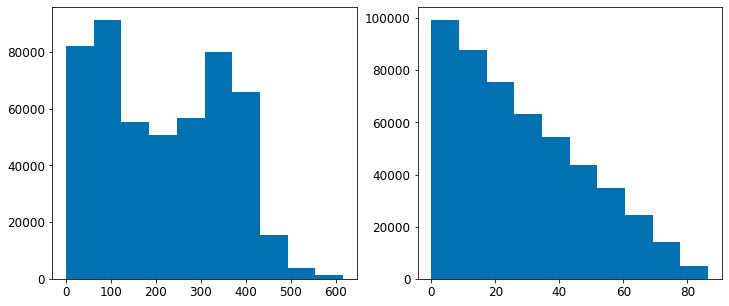

In [72]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(dX/1e3);
# min(dX), max(dX)

plt.subplot(122)
plt.hist(dTime);

In [73]:
import matplotlib.colors as colors

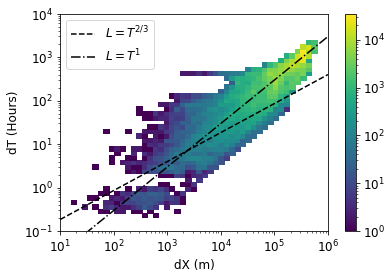

In [74]:
plt.hist2d(dX, dTime*24, bins=(np.logspace(1,6), np.logspace(-1,4)),
          norm=colors.LogNorm());
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dX (m)')
plt.ylabel('dT (Hours)')

L = np.logspace(1,6)
T23 = 4e-2*L**(2/3)
T1 = 3e-3*L
#y32 = 1e-5*x**(3/2)
plt.plot(L,T23, label='$L=T^{2/3}$', color='k', linestyle='--')
plt.plot(L,T1, label='$L=T^{1}$', color='k', linestyle='-.')

plt.legend()

Notice that the pairs that are farter away in distance are also farther separated in time. This pattern is set by the trajectory of the gliders. 
We expect that properties between points that are farther apart change slower as the changes at large scales are governed by larger structures, which evolve slower. 

However we don't know the functional relationship of how this time scale changes as a function of scale. We can make a few guesses: 
- Frozen field approx. Under this assumption, which is often made in oceanography on scale of days, the sampling is done faster than much can change. It is likley ok if the sampling duration is order a few days. 
- We say that the $T \sim L/U$, where U is a phase speed of features. The question is how does one approximate this phase speed? and is it a constant?
    - Constant phase speed gives $T = C L$, where the C needs to be guessed. 
    - Scale dependent. One choice would be to assume that the features evolve based on some power law, and a good guess would be that $|U| \sim L^{0.5 or 1}$. Exponent of 0.5 would be based on frontal scaling and 1 would be based on QG like dynamics. The QG case predicts a constant time scale 
    
The QG case predicts a constant time scale. This is weird because we did not add any information about the scales of spatial variability in the tracers in the above arguments (**think about this later**). 

##### Density gradients as a function of scale. 

In [75]:
cond = (dTime <= 2e-3*dX**(2/3)) 
#chose the constant empirically (can do this probably in some more objective way.)

Text(0.5, 1.0, 'Histogram of empirically chosen points')

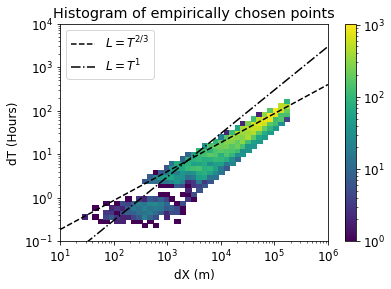

In [76]:
plt.hist2d(dX[cond], dTime[cond]*24, bins=(np.logspace(1,6), np.logspace(-1,4)),
          norm=colors.LogNorm());
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dX (m)')
plt.ylabel('dT (Hours)')

L = np.logspace(1,6)
T23 = 4e-2*L**(2/3)
T1 = 3e-3*L
#y32 = 1e-5*x**(3/2)
plt.plot(L,T23, label='$L=T^{2/3}$', color='k', linestyle='--')
plt.plot(L,T1, label='$L=T^{1}$', color='k', linestyle='-.')

plt.legend()

plt.title('Histogram of empirically chosen points')

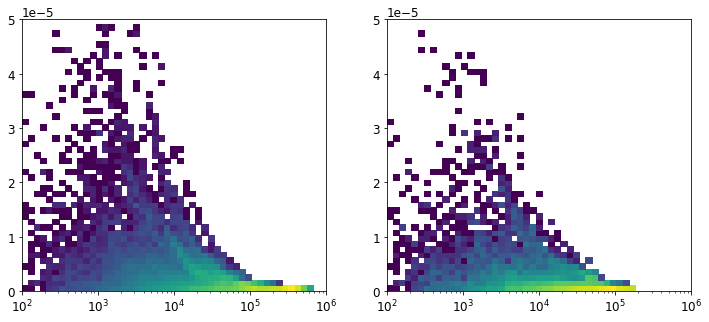

In [77]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist2d(dX, drho/dX, bins=(np.logspace(2,6), np.linspace(0, 0.5e-4)),
          norm=colors.LogNorm());
plt.xscale('log')

plt.subplot(122)
plt.hist2d(dX[cond], (drho/dX)[cond], bins=(np.logspace(2,6), np.linspace(0, 0.5e-4)),
          norm=colors.LogNorm());
plt.xscale('log')


Text(0, 0.5, '$ |d \\rho| $')

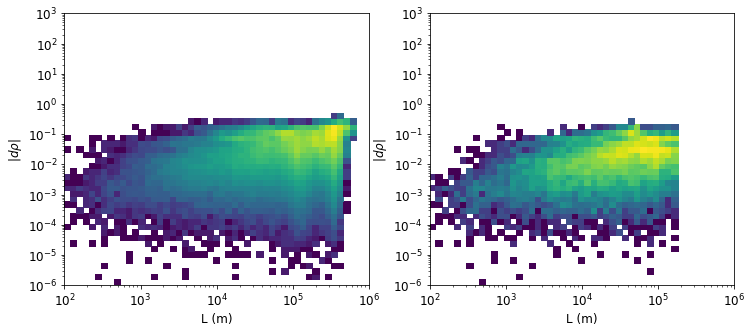

In [78]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist2d(dX, drho, bins=(np.logspace(2,6), np.logspace(-6, 3)),
          norm=colors.LogNorm());
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')
plt.ylabel(r'$ |d \rho| $')

plt.subplot(122)
plt.hist2d(dX[cond], drho[cond], bins=(np.logspace(2,6), np.logspace(-6, 3)),
          norm=colors.LogNorm());
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')
plt.ylabel(r'$ |d \rho| $')

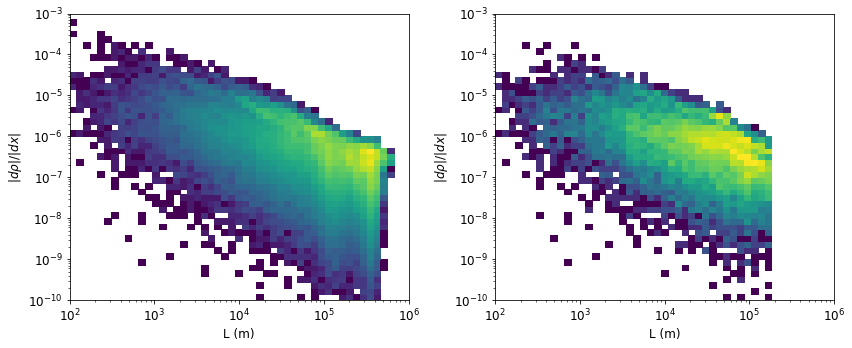

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist2d(dX, drho/dX, bins=(np.logspace(2,6), np.logspace(-10, -3)),
          norm=colors.LogNorm());
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')
plt.ylabel(r'$ |d \rho| / |dx| $')

plt.subplot(122)
plt.hist2d(dX[cond], (drho/dX)[cond], bins=(np.logspace(2,6), np.logspace(-10, -3)),
          norm=colors.LogNorm());
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')
plt.ylabel(r'$ |d \rho| / |dx| $')
plt.tight_layout()

In [80]:
Hrho, xedges, yedges = np.histogram2d(dX[cond], (drho/dX)[cond],
                                      bins=(np.logspace(2,6,31), np.logspace(-10, -3,37)))
xmid = 0.5*(xedges[0:-1] + xedges[1:])
ymid = 0.5*(yedges[0:-1] + yedges[1:])

In [81]:
Hrho_Xdnorm = Hrho/ Hrho.sum(axis=1).reshape((-1,1))

Text(0.5, 1.0, 'PDF of density gradient normalized at each scale')

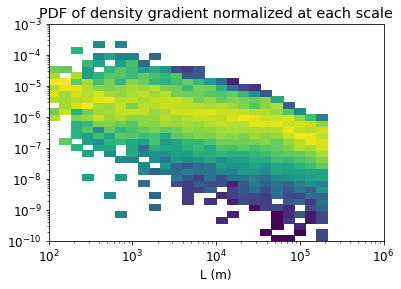

In [82]:
plt.pcolor(xedges, yedges, Hrho_Xdnorm.T, norm=colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L (m)')

plt.title('PDF of density gradient normalized at each scale')

Text(0, 0.5, 'PDF')

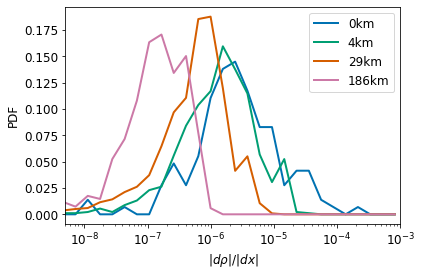

In [83]:
for i in range(6,len(xmid),6): 
    plt.plot(ymid, Hrho_Xdnorm[i,:], label=str(int(xmid[i]/1e3)) + 'km', linewidth=2)
plt.xscale('log')
plt.xlim([5e-9, 1e-3])
plt.legend()
plt.xlabel(r'$ |d \rho| / |dx| $')
plt.ylabel('PDF')

Density gradient increases as length scales get smaller. However, there seems to be a plateau to gradient at scales smaller than about 1km. This could potentially be suggestive of length scales at which fronts become stable (balance between frontogenesis and turbulence, Bodner et al 2021).  
However, a caveat should be kept in mind that at the smallest scales the instrument is being pushed by the current, which could likely be orienting the positions to be along the front and biasing the density gradients smaller than they are.

#### Density ratio as a function of scale

Look at $$R (l) = \alpha dT / \beta dS$$ and Turner angle ($Tu(l)$) as a function of scale. 

In [84]:
R_pairs = alpha*dCT/(beta*dSA)

In [85]:
Tu_pairs = np.arctan(R_pairs)

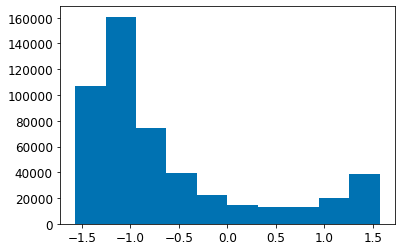

In [86]:
plt.hist(Tu_pairs);

In [87]:
H_Tu, x_Tu, y_Tu = np.histogram2d(dX[cond], Tu_pairs[cond], 
                                 bins=(np.logspace(2,6,17), np.linspace(-np.pi/2, np.pi/2,9)))
x_mid = 0.5*(x_Tu[0:-1] + x_Tu[1:])
y_mid = 0.5*(y_Tu[0:-1] + y_Tu[1:])

HTu_Xdnorm = H_Tu/ H_Tu.sum(axis=1).reshape((-1,1))

Text(0.5, 1.0, 'PDF of density ratio normalized at each scale')

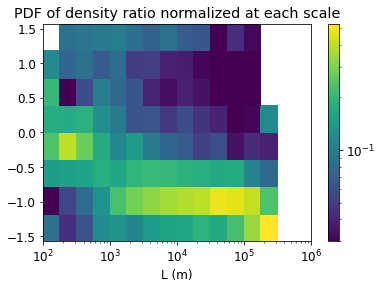

In [88]:
plt.pcolor(x_Tu, y_Tu, HTu_Xdnorm.T, norm=colors.LogNorm(vmin=3e-2))
plt.colorbar()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('L (m)')

plt.title('PDF of density ratio normalized at each scale')

Text(0, 0.5, 'PDF')

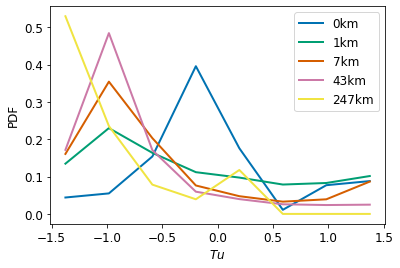

In [89]:
for i in range(1,len(x_mid),3): 
    plt.plot(y_mid, HTu_Xdnorm[i,:], label=str(int(x_mid[i]/1e3)) + 'km', linewidth=2)
#plt.xscale('log')
#plt.xlim([5e-9, 1e-3])
plt.legend()
plt.xlabel(r'$ Tu $')
plt.ylabel('PDF')

This confirms in a more quantitative manner that the Turner angle is scale dependent. At the smallest scales (<1km) the density gradients are governed largely by salinity ($Tu=0$). However at larger scales this starts to change and both temperature and salinity gradients start to contribute equally to the gradients ($Tu=-\pi/4$). It is interesting that there is no sign of compensation in this region ($Tu=\pi/4$). 

#### Key takeaways
- MLD is highly variable, more so in first half of deployment than second. 
- There are some regions with very shallow mixed layers (<50m), which seem to be made of fresh water lenses. 
- Density gradient increases at smaller scales, but seems to plateau at scales less than 1km. 
- The density gradient is a combination of T and S gradients (almost equally), except at the scales of <1km where the salinity gradient dominates the T gradient.